### Imports

In [1]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [2]:
!pip show tensorflow # Should be v2.10

Name: tensorflow


Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras # Should be v2.10

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)
reload(generators)

<module 'helpers.generators' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\generators.py'>

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
NUM_FOLDS = 10
NUM_EPOCHS = 10
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="../data/DATASET_CSVS/deepship_5k_seg_3s.csv",
    new_path_to_root="../data/deepship_baseline_unnorm_mat",
    ext="mat", 
    n_folds=NUM_FOLDS,
    unix=False
)

In [8]:
train_df, val_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=1, val_idx=0)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

del fold_dfs

(43470, 5)
(4534, 5)
(5498, 5)


In [9]:
train_gen = generators.DeepShipGenerator(
    df=train_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

val_gen = generators.DeepShipGenerator(
    df=val_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

test_gen = generators.DeepShipGenerator(
    df=test_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

### Initialise model

In [10]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [11]:
from models import unet_n2n

model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 192, 192, 64  0           ['conv2d[0][0]']                 
                                )                                                              

### Train model

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="models/saved/same_spec_denoiser_05122024/unet/{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/same_spec_denoiser_05122024/unet/training.log",
    separator=",",
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/same_spec_denoiser_05122024/unet"
)

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, csv_logger, backup_callback],
    verbose=2
)

Epoch 1/10
2716/2716 - 5746s - loss: 0.0019 - psnr: 29.9499 - val_loss: 4.3867e-04 - val_psnr: 33.7373 - 5746s/epoch - 2s/step
Epoch 2/10
2716/2716 - 6655s - loss: 2.6490e-04 - psnr: 36.0659 - val_loss: 1.7404e-04 - val_psnr: 37.7680 - 6655s/epoch - 2s/step
Epoch 3/10
2716/2716 - 6962s - loss: 1.2024e-04 - psnr: 39.4587 - val_loss: 9.2920e-05 - val_psnr: 40.4878 - 6962s/epoch - 3s/step
Epoch 4/10
2716/2716 - 6988s - loss: 6.1327e-05 - psnr: 42.3674 - val_loss: 4.6154e-05 - val_psnr: 43.5559 - 6988s/epoch - 3s/step
Epoch 5/10
2716/2716 - 7011s - loss: 3.5463e-05 - psnr: 44.7847 - val_loss: 2.7982e-05 - val_psnr: 45.7447 - 7011s/epoch - 3s/step
Epoch 6/10
2716/2716 - 7083s - loss: 2.2463e-05 - psnr: 46.7392 - val_loss: 1.9404e-05 - val_psnr: 47.3352 - 7083s/epoch - 3s/step
Epoch 7/10
2716/2716 - 7147s - loss: 1.5704e-05 - psnr: 48.3044 - val_loss: 1.8200e-05 - val_psnr: 47.5601 - 7147s/epoch - 3s/step
Epoch 8/10
2716/2716 - 7087s - loss: 1.1721e-05 - psnr: 49.5723 - val_loss: 1.0319e-05 

In [14]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

343/343 - 303s - loss: 6.4194e-06 - psnr: 52.1414 - 303s/epoch - 883ms/step


In [15]:
model.save("models/saved/same_spec_denoiser_05122024/unet/unet_denoiser.keras")

### Evaluation, metrics, and visualising denoised output

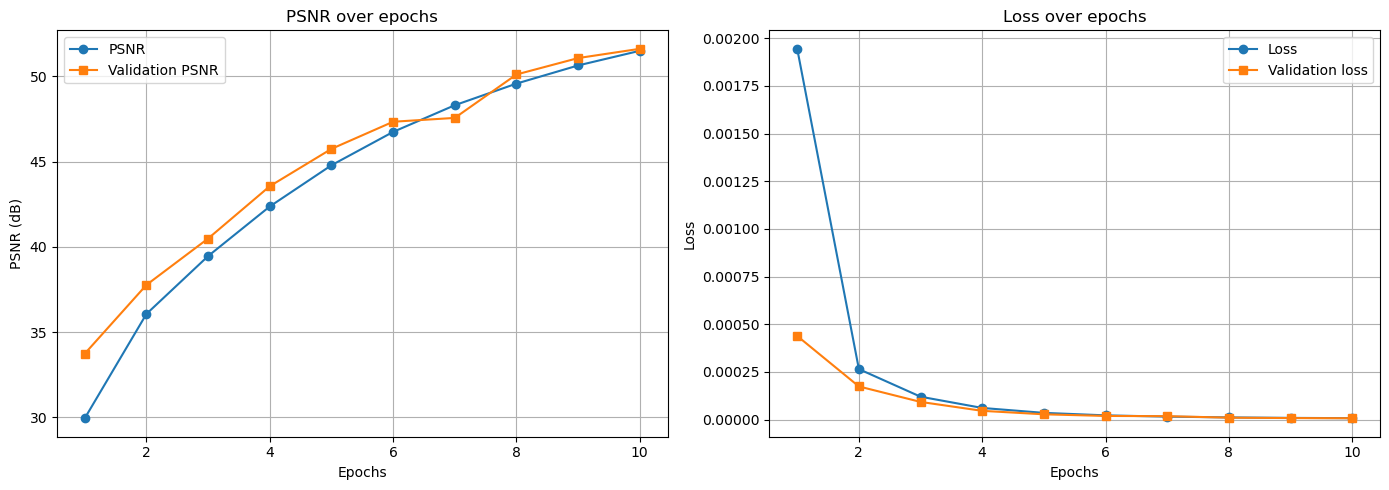

In [33]:
reload(utils)
fig = utils.get_psnr_and_loss_curves(history, together=True)
fig.savefig("models/saved/same_spec_denoiser_05122024/unet/psnr_loss_curves.pdf")

In [17]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 [==============================] - 9s 9s/step


In [18]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 7.747357813059352e-06
PSNR on sample batch: [49.882072 52.83565  51.24367  52.177525 50.13692 ]


In [19]:
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.0009842468425631523; Max: 1.0053120851516724
Sample 2 - Min: 0.008044273592531681; Max: 1.0012818574905396
Sample 3 - Min: -0.0007207557209767401; Max: 1.002313494682312
Sample 4 - Min: -0.0035580480471253395; Max: 1.0135830640792847
Sample 5 - Min: -0.005169152747839689; Max: 1.0084789991378784


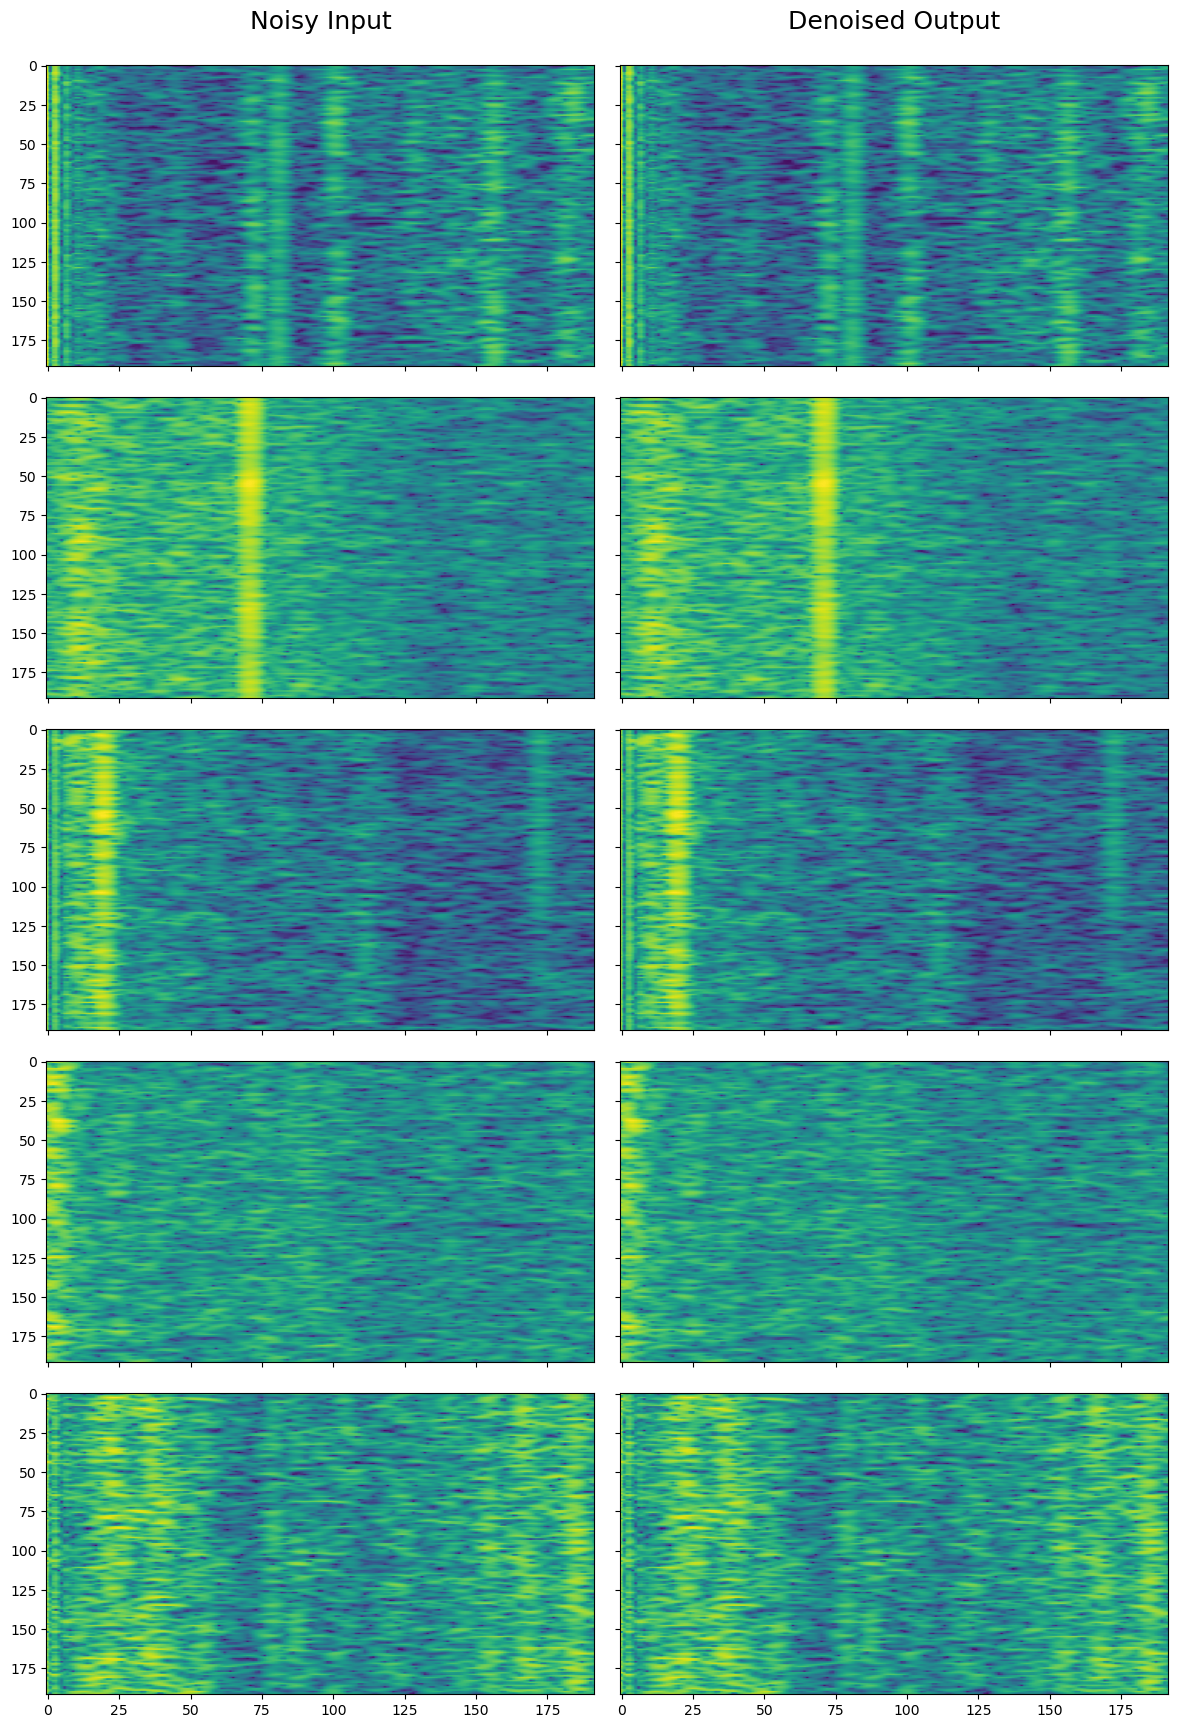

In [50]:
# Create a single figure
fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3.5), sharex=True, sharey=True)

# fig.tight_layout(pad=3.0)

for i in range(num_samples):
    axes[i, 0].imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Noisy Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output\n", fontsize=18)

fig.tight_layout(pad=1.5)
fig.savefig(f"models/saved/same_spec_denoiser_05122024/unet/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()

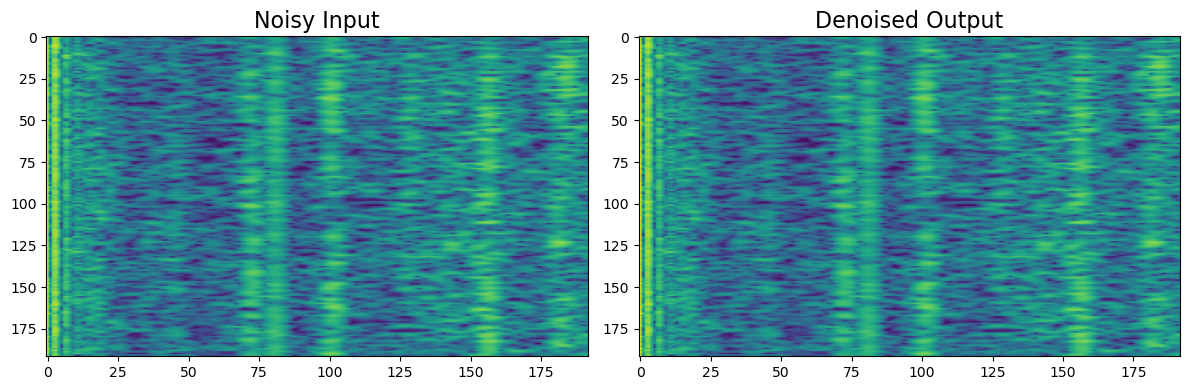

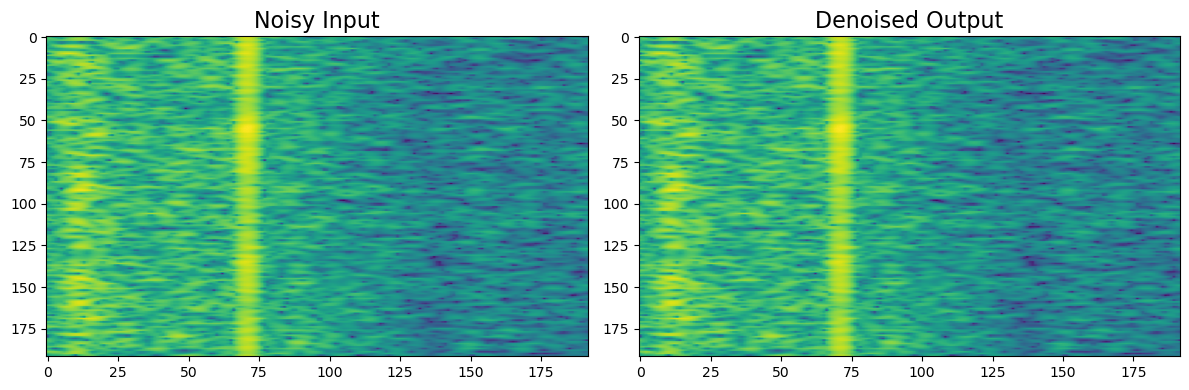

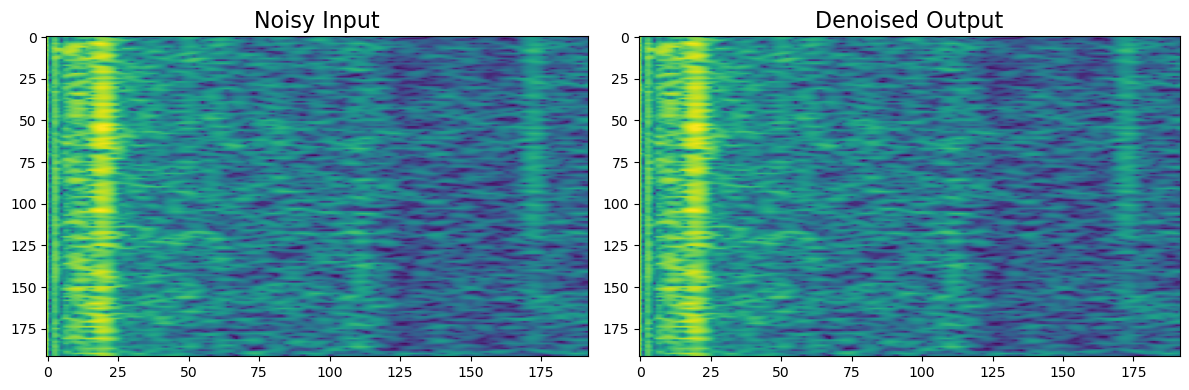

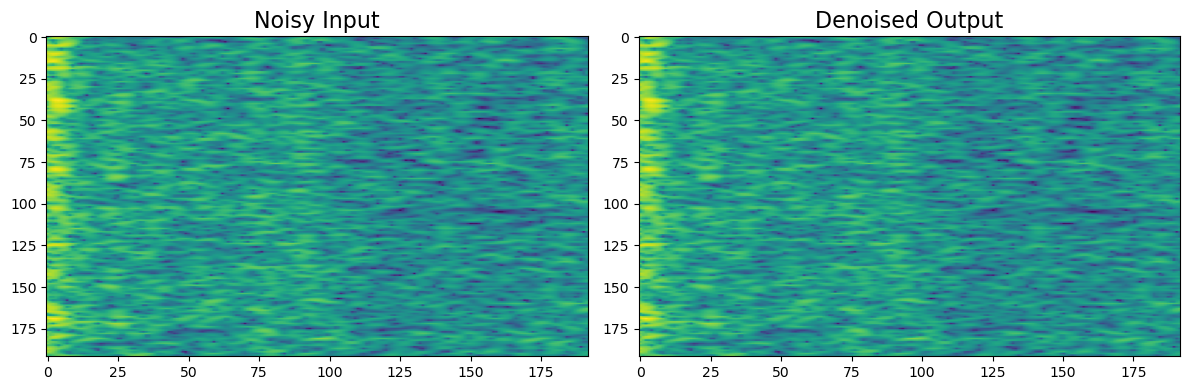

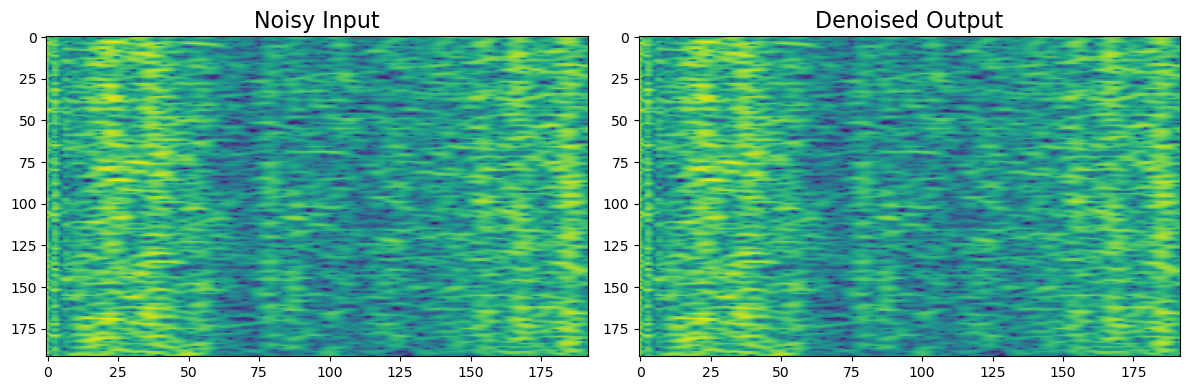

In [37]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input", fontdict={'size': 16})
    # plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output", fontdict={'size': 16})
    # plt.colorbar()

    plt.tight_layout()
    plt.show()

    fig.savefig(f"models/saved/same_spec_denoiser_05122024/unet/ex{i + 1}.pdf")